In Random Forest Model

Make comparison of RMSE estimation for two different set of bins and for dataframe with and without imbued 0s.

***Note: the highly correlated features in dataset without imbued 0s are different(only two features with correlation value greater than 10).***

In [ ]:
%load_ext jupyter_black

In [ ]:
import statistics
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error

from utils import get_clean_dataset

In [ ]:
df = get_clean_dataset()

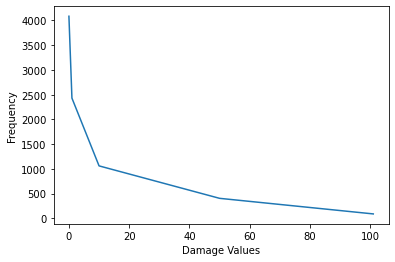

In [16]:
#The Old and New set of bins
#bins2= [0, 1, 60, 101]   #three bins
bins2 = [0, 0.00009, 1, 10, 50, 101]   #Five bins
samples_per_bin2, binsP2 = np.histogram(df['DAM_perc_dmg'], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:],samples_per_bin2)

In [17]:
print(samples_per_bin2)
print(binsP2)

[4086 2431 1061  405   90]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [18]:
df['DAM_perc_dmg'].value_counts(bins=binsP2)

(-0.001, 9e-05]    4086
(9e-05, 1.0]       2431
(1.0, 10.0]        1061
(10.0, 50.0]        405
(50.0, 101.0]        90
Name: DAM_perc_dmg, dtype: int64

In [19]:
bin_index2=np.digitize(df['DAM_perc_dmg'], bins=binsP2)

In [20]:
y_input_strat=bin_index2

In [21]:
#the Beginning time to run the model 20 times
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 01:31:31


In [22]:
#Define empty lists for bins results(test)
test_MAE_list_bin1=[]
test_MAE_list_bin2=[]
test_MAE_list_bin3=[]
test_MAE_list_bin4=[]
test_MAE_list_bin5=[]

test_RMSE_list_bin1=[]
test_RMSE_list_bin2=[]
test_RMSE_list_bin3=[]
test_RMSE_list_bin4=[]
test_RMSE_list_bin5=[]

#Define empty lists for bins results(train)
train_MAE_list_bin1=[]
train_MAE_list_bin2=[]
train_MAE_list_bin3=[]
train_MAE_list_bin4=[]
train_MAE_list_bin5=[]

train_RMSE_list_bin1=[]
train_RMSE_list_bin2=[]
train_RMSE_list_bin3=[]
train_RMSE_list_bin4=[]
train_RMSE_list_bin5=[]

In [23]:
#Dropping highly correlated features (correlation value > 0.99) from X data.
features =[
    'HAZ_rainfall_Total', 
    'HAZ_rainfall_max_6h',
    'HAZ_rainfall_max_24h',
    'HAZ_v_max',
    'HAZ_v_max_3',
    'HAZ_dis_track_min',
    'GEN_landslide_per',
    'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA', 
    #'GEN_Bu_p_LS', 
    'GEN_Red_per_LSbldg',
    'GEN_Or_per_LSblg', 
    'GEN_Yel_per_LSSAb', 
    #'GEN_RED_per_SSAbldg',
    'GEN_OR_per_SSAbldg',
    'GEN_Yellow_per_LSbl',
    'TOP_mean_slope',
    'TOP_mean_elevation_m', 
    'TOP_ruggedness_stdev', 
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev', 
    'VUL_poverty_perc',
    'GEN_with_coast',
    'GEN_coast_length', 
    'VUL_Housing_Units',
    'VUL_StrongRoof_StrongWall', 
    'VUL_StrongRoof_LightWall',
    'VUL_StrongRoof_SalvageWall', 
    'VUL_LightRoof_StrongWall',
    'VUL_LightRoof_LightWall', 
    'VUL_LightRoof_SalvageWall',
    'VUL_SalvagedRoof_StrongWall',
    'VUL_SalvagedRoof_LightWall',
    'VUL_SalvagedRoof_SalvageWall', 
    'VUL_vulnerable_groups',
    'VUL_pantawid_pamilya_beneficiary']

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["DAM_perc_dmg"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)


for i in range(20): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,df['DAM_perc_dmg'], stratify=y_input_strat, test_size=0.2)

    
    bin_index_test=np.digitize(y_test, bins=binsP2)
    bin_index_train=np.digitize(y_train, bins=binsP2)
    
    #Random Forest Reduced Overfitting
    rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5, max_samples=0.7)
    
    #Random Forest
    #rf = RandomForestRegressor(max_depth=None, n_estimators=100, min_samples_split=8,min_samples_leaf=5)
    
    rf_model=rf.fit(X_train, y_train)
    
    
    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())
    
    y_pred_train = rf.predict(X_train)
    mae_train_idx1 = mean_absolute_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    mae_train_idx2 = mean_absolute_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    mae_train_idx3 = mean_absolute_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    mae_train_idx4 = mean_absolute_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
    mae_train_idx5 = mean_absolute_error(y_train[bin_index_train==5], y_pred_train[bin_index_train==5])
    
    
    mse_train_idx1 = mean_squared_error(y_train[bin_index_train==1], y_pred_train[bin_index_train==1])
    rmse_train_1 = np.sqrt(mse_train_idx1)
    mse_train_idx2 = mean_squared_error(y_train[bin_index_train==2], y_pred_train[bin_index_train==2])
    rmse_train_2 = np.sqrt(mse_train_idx2)
    mse_train_idx3 = mean_squared_error(y_train[bin_index_train==3], y_pred_train[bin_index_train==3])
    rmse_train_3 = np.sqrt(mse_train_idx3)
    mse_train_idx4 = mean_squared_error(y_train[bin_index_train==4], y_pred_train[bin_index_train==4])
    rmse_train_4 = np.sqrt(mse_train_idx4)
    mse_train_idx5 = mean_squared_error(y_train[bin_index_train==5], y_pred_train[bin_index_train==5])
    rmse_train_5 = np.sqrt(mse_train_idx5)
    


    y_pred = rf.predict(X_test)
    mae_idx1 = mean_absolute_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    mae_idx2 = mean_absolute_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    mae_idx3 = mean_absolute_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    mae_idx4 = mean_absolute_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
    mae_idx5 = mean_absolute_error(y_test[bin_index_test==5], y_pred[bin_index_test==5])

    mse_idx1 = mean_squared_error(y_test[bin_index_test==1], y_pred[bin_index_test==1])
    rmse_1 = np.sqrt(mse_idx1)
    mse_idx2 = mean_squared_error(y_test[bin_index_test==2], y_pred[bin_index_test==2])
    rmse_2 = np.sqrt(mse_idx2)
    mse_idx3 = mean_squared_error(y_test[bin_index_test==3], y_pred[bin_index_test==3])
    rmse_3 = np.sqrt(mse_idx3)
    mse_idx4 = mean_squared_error(y_test[bin_index_test==4], y_pred[bin_index_test==4])
    rmse_4 = np.sqrt(mse_idx4)
    mse_idx5 = mean_squared_error(y_test[bin_index_test==5], y_pred[bin_index_test==5])
    rmse_5 = np.sqrt(mse_idx5)
    
    
    print('----- Training_bins_MAE  ------')
    print(f'Mean absolute error of bins_1: {mae_train_idx1:.2f}')
    print(f'Mean absolute error of bins_2: {mae_train_idx2:.2f}')
    print(f'Mean absolute error of bins_3: {mae_train_idx3:.2f}')
    print(f'Mean absolute error of bins_4: {mae_train_idx4:.2f}')
    print(f'Mean absolute error of bins_5: {mae_train_idx5:.2f}')
    
    print('----- Training_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_train_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_train_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_train_3:.2f}')
    print(f'Root mean squared error of bins_4: {rmse_train_4:.2f}')
    print(f'Root mean squared error of bins_5: {rmse_train_5:.2f}')
    
    train_MAE_list_bin1.append(mae_train_idx1)
    train_MAE_list_bin2.append(mae_train_idx2)
    train_MAE_list_bin3.append(mae_train_idx3)
    train_MAE_list_bin4.append(mae_train_idx4)
    train_MAE_list_bin5.append(mae_train_idx5)
    
    train_RMSE_list_bin1.append(rmse_train_1)
    train_RMSE_list_bin2.append(rmse_train_2)
    train_RMSE_list_bin3.append(rmse_train_3)
    train_RMSE_list_bin4.append(rmse_train_4)
    train_RMSE_list_bin5.append(rmse_train_5)
    
    
    print('----- Test_bins_MAE  ------')
    print(f'Mean absolute error of bins_1: {mae_idx1:.2f}')
    print(f'Mean absolute error of bins_2: {mae_idx2:.2f}')
    print(f'Mean absolute error of bins_3: {mae_idx3:.2f}')
    print(f'Mean absolute error of bins_4: {mae_idx4:.2f}')
    print(f'Mean absolute error of bins_5: {mae_idx5:.2f}')
    
    print('----- Test_bins_RMSE  ------')
    print(f'Root mean squared error of bins_1: {rmse_1:.2f}')
    print(f'Root mean squared error of bins_2: {rmse_2:.2f}')
    print(f'Root mean squared error of bins_3: {rmse_3:.2f}')
    print(f'Root mean squared error of bins_4: {rmse_4:.2f}')
    print(f'Root mean squared error of bins_5: {rmse_5:.2f}')
    
    test_MAE_list_bin1.append(mae_idx1)
    test_MAE_list_bin2.append(mae_idx2)
    test_MAE_list_bin3.append(mae_idx3)
    test_MAE_list_bin4.append(mae_idx4)
    test_MAE_list_bin5.append(mae_idx5)
    
    test_RMSE_list_bin1.append(rmse_1)
    test_RMSE_list_bin2.append(rmse_2)
    test_RMSE_list_bin3.append(rmse_3)
    test_RMSE_list_bin4.append(rmse_4)
    test_RMSE_list_bin5.append(rmse_5)
      

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_OR_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     176.0
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:31:45   Log-Likelihood:                -21506.
No. Observations:                6458   AIC:                         4.308e+04
Df Residuals:                    6426   BIC:                         4.329e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4667      0.084     29.229      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     185.5
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:31:58   Log-Likelihood:                -21505.
No. Observations:                6458   AIC:                         4.307e+04
Df Residuals:                    6426   BIC:                         4.329e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4842      0.084     29.451      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     191.4
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:32:11   Log-Likelihood:                -21408.
No. Observations:                6458   AIC:                         4.288e+04
Df Residuals:                    6426   BIC:                         4.310e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4815      0.083     29.854      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     184.7
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:32:23   Log-Likelihood:                -21346.
No. Observations:                6458   AIC:                         4.276e+04
Df Residuals:                    6426   BIC:                         4.297e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4508      0.082     29.772      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     176.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:32:35   Log-Likelihood:                -21499.
No. Observations:                6458   AIC:                         4.306e+04
Df Residuals:                    6426   BIC:                         4.328e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4905      0.084     29.545      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     183.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:32:47   Log-Likelihood:                -21542.
No. Observations:                6458   AIC:                         4.315e+04
Df Residuals:                    6426   BIC:                         4.336e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4726      0.085     29.136      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     181.8
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:32:59   Log-Likelihood:                -21490.
No. Observations:                6458   AIC:                         4.304e+04
Df Residuals:                    6426   BIC:                         4.326e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4973      0.084     29.675      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     182.3
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:33:11   Log-Likelihood:                -21479.
No. Observations:                6458   AIC:                         4.302e+04
Df Residuals:                    6426   BIC:                         4.324e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4704      0.084     29.398      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     171.6
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:33:23   Log-Likelihood:                -21544.
No. Observations:                6458   AIC:                         4.315e+04
Df Residuals:                    6426   BIC:                         4.337e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4754      0.085     29.166      0.0

                            OLS Regression Results                            
Dep. Variable:           DAM_perc_dmg   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     171.1
Date:                Thu, 10 Nov 2022   Prob (F-statistic):               0.00
Time:                        01:33:36   Log-Likelihood:                -21567.
No. Observations:                6458   AIC:                         4.320e+04
Df Residuals:                    6426   BIC:                         4.341e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4767      0.085     29.068      0.0

In [24]:
#the End time of running the model 20 times
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-10 01:33:41


stdev_RMSE_test: 0.15
stdev_RMSE_train: 0.07
mean_RMSE_test: 0.80
mean_RMSE_train: 0.60


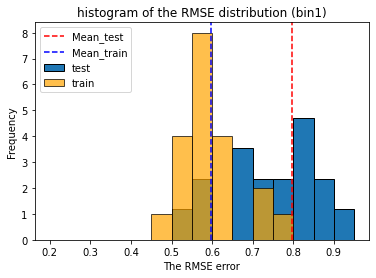

In [30]:
#RMSE of bins_1

m_test_rmse = statistics.mean(test_RMSE_list_bin1)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin1, bins=np.arange(0.2,1.0,0.05), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin1)


m_train_rmse = statistics.mean(train_RMSE_list_bin1)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin1, bins=np.arange(0.2,1.0,0.05), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin1)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin1)')
plt.show()

stdev_RMSE_test: 0.31
stdev_RMSE_train: 0.05
mean_RMSE_test: 2.55
mean_RMSE_train: 1.84


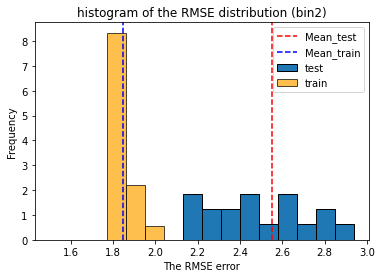

In [33]:
#RMSE of bins_2

m_test_rmse = statistics.mean(test_RMSE_list_bin2)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin2, bins=np.arange(1.5,3.0,0.09), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin2)


m_train_rmse = statistics.mean(train_RMSE_list_bin2)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin2, bins=np.arange(1.5,3.0,0.09), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin2)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin2)')
plt.show()

stdev_RMSE_test: 0.59
stdev_RMSE_train: 0.09
mean_RMSE_test: 5.51
mean_RMSE_train: 4.03


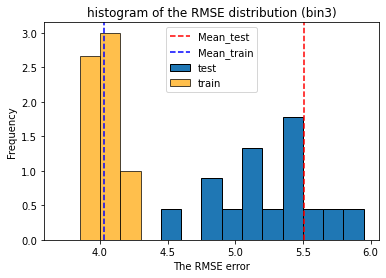

In [41]:
#RMSE of bins_3

m_test_rmse = statistics.mean(test_RMSE_list_bin3)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin3, bins=np.arange(3.7,6.0,0.15), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin3)


m_train_rmse = statistics.mean(train_RMSE_list_bin3)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin3, bins=np.arange(3.7,6.0,0.15), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7)
sd_train_rmse = statistics.stdev(train_RMSE_list_bin3)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin3)')
plt.show()

stdev_RMSE_test: 1.25
stdev_RMSE_train: 0.23
mean_RMSE_test: 14.45
mean_RMSE_train: 10.67


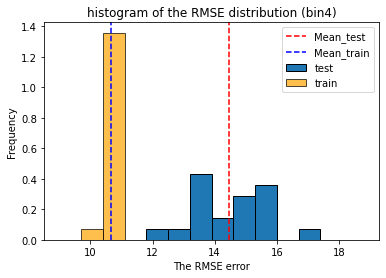

In [47]:
#RMSE of bins_4

m_test_rmse = statistics.mean(test_RMSE_list_bin4)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin4, bins=np.arange(9.0,19.0,0.7), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin4)


m_train_rmse = statistics.mean(train_RMSE_list_bin4)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin4, bins=np.arange(9.0,19.0,0.7), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin4)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin4)')
plt.show()

stdev_RMSE_test: 3.73
stdev_RMSE_train: 0.90
mean_RMSE_test: 41.27
mean_RMSE_train: 30.79


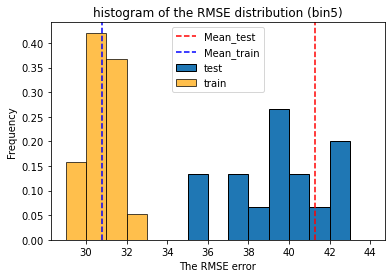

In [51]:
#RMSE of bins_5

m_test_rmse = statistics.mean(test_RMSE_list_bin5)
plt.axvline(m_test_rmse, color='red', linestyle='dashed')
plt.hist(test_RMSE_list_bin5, bins=np.arange(29.0,45.0,1.0), edgecolor='k', histtype ='bar', density=True)
sd_test_rmse = statistics.stdev(test_RMSE_list_bin5)


m_train_rmse = statistics.mean(train_RMSE_list_bin5)
plt.axvline(m_train_rmse, color='b', linestyle='dashed')
plt.hist(train_RMSE_list_bin5, bins=np.arange(29.0,45.0,1.0), color='orange', edgecolor='k', histtype ='bar',
         density=True, alpha=0.7, #bins=np.arange(40.0,50.0,0.55)
        )
sd_train_rmse = statistics.stdev(train_RMSE_list_bin5)

print(f'stdev_RMSE_test: {sd_test_rmse:.2f}')
print(f'stdev_RMSE_train: {sd_train_rmse:.2f}')

print(f'mean_RMSE_test: {m_test_rmse:.2f}')
print(f'mean_RMSE_train: {m_train_rmse:.2f}')

#create legend
labels= ["Mean_test","Mean_train","test","train"]
plt.legend(labels)

plt.xlabel('The RMSE error')
plt.ylabel('Frequency')
plt.title('histogram of the RMSE distribution (bin5)')
plt.show()